In [2]:
%matplotlib inline

In [21]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b186ba07f8328c75205a5e6d460f1f8498cc7681304208382789e4488e13f875
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
os.chdir('/content/drive/MyDrive')
data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


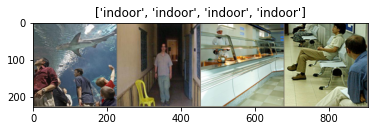

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # loss.requires_grad = True
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet

In [29]:
model_ft = EfficientNet.from_pretrained('efficientnet-b0')
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to  len(class_names)
model_ft._fc.out_features = 2
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.1174 Acc: 0.6400
val Loss: 2.1373 Acc: 0.6200

Epoch 1/24
----------
train Loss: 0.4555 Acc: 0.8323
val Loss: 1.5452 Acc: 0.7267

Epoch 2/24
----------
train Loss: 0.4029 Acc: 0.8369
val Loss: 1.5568 Acc: 0.7133

Epoch 3/24
----------
train Loss: 0.3113 Acc: 0.8677
val Loss: 1.4331 Acc: 0.7600

Epoch 4/24
----------
train Loss: 0.2849 Acc: 0.8877
val Loss: 1.2908 Acc: 0.7667

Epoch 5/24
----------
train Loss: 0.2324 Acc: 0.9092
val Loss: 1.2806 Acc: 0.7667

Epoch 6/24
----------
train Loss: 0.2718 Acc: 0.9000
val Loss: 1.0293 Acc: 0.8400

Epoch 7/24
----------
train Loss: 0.2503 Acc: 0.9046
val Loss: 1.1970 Acc: 0.7867

Epoch 8/24
----------
train Loss: 0.2597 Acc: 0.8969
val Loss: 1.1752 Acc: 0.7867

Epoch 9/24
----------
train Loss: 0.2858 Acc: 0.8892
val Loss: 1.1755 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.2437 Acc: 0.8969
val Loss: 1.1626 Acc: 0.8000

Epoch 11/24
----------
train Loss: 0.2177 Acc: 0.9200
val Loss: 1.1454 Acc: 0.8000

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


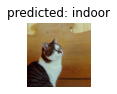

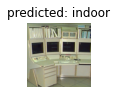

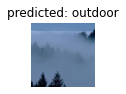

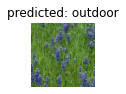

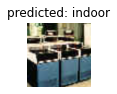

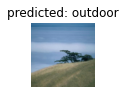

In [31]:
visualize_model(model_ft)

ConvNet as fixed feature extractor


In [48]:
model_conv = EfficientNet.from_pretrained('efficientnet-b0')
for param in model_conv.parameters():
    param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv._fc.in_features
model_conv._fc =  nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv._fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [49]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5380 Acc: 0.7585
val Loss: 0.4238 Acc: 0.8867

Epoch 1/24
----------
train Loss: 0.3829 Acc: 0.8492
val Loss: 0.3874 Acc: 0.8800

Epoch 2/24
----------
train Loss: 0.3814 Acc: 0.8354
val Loss: 0.3780 Acc: 0.8533

Epoch 3/24
----------
train Loss: 0.3353 Acc: 0.8738
val Loss: 0.3636 Acc: 0.8600

Epoch 4/24
----------
train Loss: 0.3697 Acc: 0.8400
val Loss: 0.3492 Acc: 0.8600

Epoch 5/24
----------
train Loss: 0.3797 Acc: 0.8354
val Loss: 0.3849 Acc: 0.8400

Epoch 6/24
----------
train Loss: 0.3612 Acc: 0.8477
val Loss: 0.3649 Acc: 0.8400

Epoch 7/24
----------
train Loss: 0.3211 Acc: 0.8708
val Loss: 0.3668 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.3427 Acc: 0.8431
val Loss: 0.3651 Acc: 0.8400

Epoch 9/24
----------
train Loss: 0.3473 Acc: 0.8538
val Loss: 0.3662 Acc: 0.8533

Epoch 10/24
----------
train Loss: 0.3029 Acc: 0.8908
val Loss: 0.3679 Acc: 0.8400

Epoch 11/24
----------
train Loss: 0.3098 Acc: 0.8815
val Loss: 0.3685 Acc: 0.8333

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


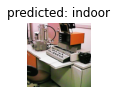

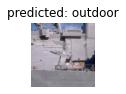

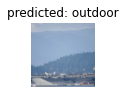

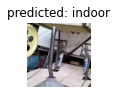

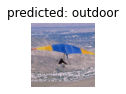

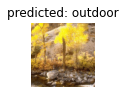

In [50]:
visualize_model(model_conv)

plt.ioff()
plt.show()